In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import descartes
from shapely.geometry import Point, Polygon

### Cumulative outflow and inflow for the last 5 years

Import data sets

In [2]:
stations_centract_df = pd.read_csv('../Data/stations_census_tracts.csv')

#get the 2010 census tract neighborhoods in Pittsburgh
cenTract = gpd.read_file('../Data/2010_Census_Tracts/a36fc9b1-4e53-4fd1-80fb-db1554e213422020328-1-nbfxcj.l6b8.shp')


#find the centroids of each neighborhood for labeling
cenTract["center"] = cenTract["geometry"].centroid
map_points = cenTract.copy()
map_points.set_geometry("center", inplace = True)

/Users/katelyncmorrison/opt/anaconda3/envs/CURF/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [3]:
from pathlib import Path

#set path to access all json files in January folder
data_dir = Path('../Data') / 'TripData'
data_files = data_dir.glob('*.csv')

list_df = []

for file in data_files:
    print(file)
    df = pd.read_csv(file, low_memory=False)
#     print(df.columns)
    list_df.append(df)
    
final_df = pd.concat(list_df, ignore_index=True)

../Data/TripData/trip_data_2016Q4.csv
../Data/TripData/trip_data_2016Q1.csv
../Data/TripData/trip_data_2016Q3.csv
../Data/TripData/trip_data_2016Q2.csv
../Data/TripData/trip_data_2017Q4.csv
../Data/TripData/trip_data_2015Q4.csv
../Data/TripData/trip_data_2017Q3.csv
../Data/TripData/trip_data_2017Q2.csv
../Data/TripData/trip_data_2015Q2.csv
../Data/TripData/trip_data_2015Q3.csv
../Data/TripData/trip_data_2017Q1.csv
../Data/TripData/trip_data_2019Q3.csv
../Data/TripData/trip_data_2019Q2.csv
../Data/TripData/trip_data_2020Q4.csv
../Data/TripData/trip_data_2019Q1.csv
../Data/TripData/trip_data_2020Q1.csv
../Data/TripData/trip_data_2019Q4.csv
../Data/TripData/trip_data_2020Q2.csv
../Data/TripData/trip_data_2020Q3.csv
../Data/TripData/trip_data_2018Q1.csv
../Data/TripData/trip_data_2018Q3.csv
../Data/TripData/trip_data_2018Q2.csv
../Data/TripData/trip_data_2018Q4.csv


In [4]:
final_df

Trip id         Starttime          Stoptime   Bikeid  \
0        24420718.0    10/1/2016 1:51    10/1/2016 2:01  70233.0   
1        24420723.0    10/1/2016 1:51    10/1/2016 2:00  70103.0   
2        24420960.0    10/1/2016 2:18    10/1/2016 3:06  70197.0   
3        24421083.0    10/1/2016 2:28    10/1/2016 2:47  70372.0   
4        24421586.0    10/1/2016 3:05    10/1/2016 3:17  70126.0   
...             ...               ...               ...      ...   
1500928  63847963.0  12/30/2018 21:00  12/30/2018 21:10  70067.0   
1500929  63848044.0  12/30/2018 21:41  12/30/2018 22:07  70398.0   
1500930  63848066.0  12/30/2018 21:50  12/30/2018 22:00  70302.0   
1500931  63848091.0  12/30/2018 22:17  12/30/2018 22:24  70150.0   
1500932  63848092.0  12/30/2018 22:17  12/31/2018 12:07  70229.0   

         Tripduration  From station id  \
0               598.0           1018.0   
1               497.0           1018.0   
2              2887.0           1036.0   
3              1154.0           1000.0   
4               675.0           1041.0   
...               ...              ...   
1500928         571.0           1041.0   
1500929        1605.0           1045.0   
1500930         611.0          49691.0   
1500931         402.0           1012.0   
1500932       49800.0           1012.0   

                                         From station name  To station id  \
0                                  Butler St & Stanton Ave         1017.0   
1                                  Butler St & Stanton Ave         1017.0   
2        Schenley Dr at Schenley Plaza (Carnegie Librar...         1034.0   
3                                 Liberty Ave & Stanwix St         1049.0   
4                                 Fifth Ave & S Bouquet St         1033.0   
...                                                    ...            ...   
1500928                           Fifth Ave & S Bouquet St         1088.0   
1500929           S 27th St & Sidney St. (Southside Works)         1022.0   
1500930                               Liberty Ave & 6th St         1014.0   
1500931           North Shore Trail & Fort Duquesne Bridge         1001.0   
1500932           North Shore Trail & Fort Duquesne Bridge         1001.0   

                                           To station name    Usertype  
0                                       21st St & Penn Ave    Customer  
1                                       21st St & Penn Ave  Subscriber  
2                             Ellsworth Ave & N Neville St    Customer  
3                                  S 12th St & E Carson St  Subscriber  
4                                    Ivy St & Walnut St       Customer  
...                                                    ...         ...  
1500928                             Frazier St & Dawson St    Customer  
1500929  Liberty Ave & S Millvale Ave (West Penn Hospital)  Subscriber  
1500930                     Ridge Ave & Brighton Rd (CCAC)  Subscriber  
1500931                         Forbes Ave & Market Square  Subscriber  
1500932                         Forbes Ave & Market Square    Customer  

[1500933 rows x 10 columns]

#### Counting outflow first

In [5]:
final_df['Starttime'] = pd.to_datetime(final_df['Starttime'])
final_df = final_df.rename(columns = {'From station id' : 'from_station_id', 'To station id': 'to_station_id'})
final_df = final_df[final_df['Tripduration'] > 60.0] #tripduration is in seconds. We want to filter out trips that were less than 1 minute

In [6]:
final_df = final_df.drop(columns=['Usertype', 'Stoptime', 'Bikeid', 'From station name', 'To station name'])

In [7]:
final_df

Trip id           Starttime  Tripduration  from_station_id  \
0        24420718.0 2016-10-01 01:51:00         598.0           1018.0   
1        24420723.0 2016-10-01 01:51:00         497.0           1018.0   
2        24420960.0 2016-10-01 02:18:00        2887.0           1036.0   
3        24421083.0 2016-10-01 02:28:00        1154.0           1000.0   
4        24421586.0 2016-10-01 03:05:00         675.0           1041.0   
...             ...                 ...           ...              ...   
1500928  63847963.0 2018-12-30 21:00:00         571.0           1041.0   
1500929  63848044.0 2018-12-30 21:41:00        1605.0           1045.0   
1500930  63848066.0 2018-12-30 21:50:00         611.0          49691.0   
1500931  63848091.0 2018-12-30 22:17:00         402.0           1012.0   
1500932  63848092.0 2018-12-30 22:17:00       49800.0           1012.0   

         to_station_id  
0               1017.0  
1               1017.0  
2               1034.0  
3               1049.0  
4               1033.0  
...                ...  
1500928         1088.0  
1500929         1022.0  
1500930         1014.0  
1500931         1001.0  
1500932         1001.0  

[498173 rows x 5 columns]

### combine station id with tract number

In [8]:
tract_station = stations_centract_df.drop(columns=['Station_Name', 'NumRacks'])
tract_station = tract_station.rename(columns={'Station #':'station_id'})

In [9]:
#fix tract number for PGH
def fixtract(df, column):
    for row, col in df.iterrows():
        #fix census tract number
        tract = df.loc[row][column]
        if len(tract) < 6:
            tract = '0' + tract
        df.at[row, column] = tract
        
    return df

In [10]:
final_df = final_df.set_index('Starttime')
final_df

Trip id  Tripduration  from_station_id  to_station_id
Starttime                                                                    
2016-10-01 01:51:00  24420718.0         598.0           1018.0         1017.0
2016-10-01 01:51:00  24420723.0         497.0           1018.0         1017.0
2016-10-01 02:18:00  24420960.0        2887.0           1036.0         1034.0
2016-10-01 02:28:00  24421083.0        1154.0           1000.0         1049.0
2016-10-01 03:05:00  24421586.0         675.0           1041.0         1033.0
...                         ...           ...              ...            ...
2018-12-30 21:00:00  63847963.0         571.0           1041.0         1088.0
2018-12-30 21:41:00  63848044.0        1605.0           1045.0         1022.0
2018-12-30 21:50:00  63848066.0         611.0          49691.0         1014.0
2018-12-30 22:17:00  63848091.0         402.0           1012.0         1001.0
2018-12-30 22:17:00  63848092.0       49800.0           1012.0         1001.0

[498173 rows x 4 columns]

In [11]:
outflow_df_M = final_df.groupby('from_station_id').resample('M').count()
outflow_df_M = outflow_df_M.drop(columns=['from_station_id','to_station_id', 'Tripduration'])
outflow_df_M = outflow_df_M.reset_index()
outflow_df_M['from_station_id'] = outflow_df_M['from_station_id'].astype(int)
outflow_df_M = outflow_df_M.rename(columns={'from_station_id': 'station_id', 'Trip id':'outflow_count'})
outflow_df_M = outflow_df_M.merge(tract_station, on='station_id')
outflow_df_M['tractce10'] = outflow_df_M['tractce10'].astype(str)
outflow_df_M = fixtract(outflow_df_M, 'tractce10')
# outflow_df_M = outflow_df_M[outflow_df_M['Starttime'] >= '2018']
outflow_df_M

station_id  Starttime  outflow_count   Latitude  Longitude  \
0           1000 2015-05-31             43  40.441326 -80.004679   
1           1000 2015-06-30            615  40.441326 -80.004679   
2           1000 2015-07-31            711  40.441326 -80.004679   
3           1000 2015-08-31            692  40.441326 -80.004679   
4           1000 2015-09-30            419  40.441326 -80.004679   
...          ...        ...            ...        ...        ...   
4671       49951 2020-08-31             94  40.465299 -79.965277   
4672       49951 2020-09-30             83  40.465299 -79.965277   
4673       49951 2020-10-31             79  40.465299 -79.965277   
4674       49951 2020-11-30             37  40.465299 -79.965277   
4675       49951 2020-12-31             18  40.465299 -79.965277   

                                 coordinates tractce10  
0               POINT (-80.004679 40.441326)    020100  
1               POINT (-80.004679 40.441326)    020100  
2               POINT (-80.004679 40.441326)    020100  
3               POINT (-80.004679 40.441326)    020100  
4               POINT (-80.004679 40.441326)    020100  
...                                      ...       ...  
4671  POINT (-79.96527672000001 40.46529884)    060300  
4672  POINT (-79.96527672000001 40.46529884)    060300  
4673  POINT (-79.96527672000001 40.46529884)    060300  
4674  POINT (-79.96527672000001 40.46529884)    060300  
4675  POINT (-79.96527672000001 40.46529884)    060300  

[4676 rows x 7 columns]

In [12]:
pivot_M = pd.pivot_table(outflow_df_M, values='outflow_count', index=['station_id','tractce10'],
                    columns=['Starttime'])
pivot_M

Starttime             2015-05-31  2015-06-30  2015-07-31  2015-08-31  \
station_id tractce10                                                   
1000       020100           43.0       615.0       711.0       692.0   
1001       020100           99.0       550.0       851.0       706.0   
1002       020100            5.0       138.0       210.0       230.0   
1003       020100            3.0       151.0       201.0       169.0   
1004       020100           22.0       173.0       295.0       311.0   
...                          ...         ...         ...         ...   
49781      010300            NaN         NaN         NaN         NaN   
49801      240600            NaN         NaN         NaN         NaN   
49881      250300            NaN         NaN         NaN         NaN   
49921      981200            NaN         NaN         NaN         NaN   
49951      060300            NaN         NaN         NaN         NaN   

Starttime             2015-09-30  2015-10-31  2015-11-30  2015-12-31  \
station_id tractce10                                                   
1000       020100          419.0       225.0       167.0       139.0   
1001       020100          536.0       232.0       166.0       112.0   
1002       020100          203.0        91.0        61.0        54.0   
1003       020100          138.0        79.0        61.0        67.0   
1004       020100          253.0       179.0       126.0        58.0   
...                          ...         ...         ...         ...   
49781      010300            NaN         NaN         NaN         NaN   
49801      240600            NaN         NaN         NaN         NaN   
49881      250300            NaN         NaN         NaN         NaN   
49921      981200            NaN         NaN         NaN         NaN   
49951      060300            NaN         NaN         NaN         NaN   

Starttime             2016-01-31  2016-02-29  ...  2020-03-31  2020-04-30  \
station_id tractce10                          ...                           
1000       020100           55.0        81.0  ...       177.0       164.0   
1001       020100           43.0       100.0  ...        96.0        64.0   
1002       020100           22.0        35.0  ...        73.0        38.0   
1003       020100           35.0        49.0  ...        46.0        36.0   
1004       020100           31.0        73.0  ...        33.0        52.0   
...                          ...         ...  ...         ...         ...   
49781      010300            NaN         NaN  ...         8.0        10.0   
49801      240600            NaN         NaN  ...       103.0        80.0   
49881      250300            NaN         NaN  ...        30.0        25.0   
49921      981200            NaN         NaN  ...        34.0        36.0   
49951      060300            NaN         NaN  ...        21.0        47.0   

Starttime             2020-05-31  2020-06-30  2020-07-31  2020-08-31  \
station_id tractce10                                                   
1000       020100          683.0       632.0      1069.0      1071.0   
1001       020100          412.0       266.0       336.0       456.0   
1002       020100          106.0        98.0       116.0       171.0   
1003       020100           91.0        54.0        76.0       107.0   
1004       020100          255.0       199.0       143.0       132.0   
...                          ...         ...         ...         ...   
49781      010300           12.0        24.0        29.0        20.0   
49801      240600          209.0       181.0       233.0       269.0   
49881      250300           53.0        43.0        43.0        29.0   
49921      981200          139.0       153.0       208.0       149.0   
49951      060300           62.0        81.0        70.0        94.0   

Starttime             2020-09-30  2020-10-31  2020-11-30  2020-12-31  
station_id tractce10                                                  
1000       020100          695.0       305.0 

In [13]:
pivot_M.to_csv('../Data/PGH/outflow_pgh_monthly.csv')

In [11]:
outflow_df = final_df.groupby('from_station_id').resample('Y').count()
outflow_df = outflow_df.drop(columns=['from_station_id','to_station_id', 'Tripduration'])
outflow_df = outflow_df.reset_index()
outflow_df['from_station_id'] = outflow_df['from_station_id'].astype(int)
outflow_df = outflow_df.rename(columns={'from_station_id': 'station_id', 'Trip id':'outflow_count'})
outflow_df = outflow_df.merge(tract_station, on='station_id')
outflow_df['tractce10'] = outflow_df['tractce10'].astype(str)
outflow_df = fixtract(outflow_df, 'tractce10')
outflow_df = outflow_df[outflow_df['Starttime'] >= '2018']
outflow_df

station_id  Starttime  outflow_count   Latitude  Longitude  \
3          1000 2018-12-31           3834  40.441326 -80.004679   
4          1000 2019-12-31           4126  40.441326 -80.004679   
5          1000 2020-12-31           5204  40.441326 -80.004679   
9          1001 2018-12-31           3654  40.440877 -80.003080   
10         1001 2019-12-31           3301  40.440877 -80.003080   
..          ...        ...            ...        ...        ...   
435       49921 2019-12-31            587  40.447412 -80.012065   
436       49921 2020-12-31            948  40.447412 -80.012065   
437       49951 2018-12-31            255  40.465299 -79.965277   
438       49951 2019-12-31            696  40.465299 -79.965277   
439       49951 2020-12-31            621  40.465299 -79.965277   

                                coordinates tractce10  
3              POINT (-80.004679 40.441326)    020100  
4              POINT (-80.004679 40.441326)    020100  
5              POINT (-80.004679 40.441326)    020100  
9               POINT (-80.00308 40.440877)    020100  
10              POINT (-80.00308 40.440877)    020100  
..                                      ...       ...  
435        POINT (-80.01206517 40.44741245)    981200  
436        POINT (-80.01206517 40.44741245)    981200  
437  POINT (-79.96527672000001 40.46529884)    060300  
438  POINT (-79.96527672000001 40.46529884)    060300  
439  POINT (-79.96527672000001 40.46529884)    060300  

[291 rows x 7 columns]

In [12]:
pivot = pd.pivot_table(outflow_df, values='outflow_count', index=['station_id','tractce10'],
                    columns=['Starttime'])
pivot

Starttime             2018-12-31  2019-12-31  2020-12-31
station_id tractce10                                    
1000       020100         3834.0      4126.0      5204.0
1001       020100         3654.0      3301.0      2415.0
1002       020100         1498.0      1302.0      1033.0
1003       020100         1310.0       976.0       612.0
1004       020100         1262.0      1212.0      1077.0
...                          ...         ...         ...
49781      010300           18.0       191.0       157.0
49801      240600            NaN       593.0      1572.0
49881      250300           19.0       433.0       330.0
49921      981200           29.0       587.0       948.0
49951      060300          255.0       696.0       621.0

[100 rows x 3 columns]

In [13]:
pivot['pred_outflow'] = pivot.mean(axis=1)
pivot['pred_outflow'] = pivot.pred_outflow.astype(int)
pivot = pivot.reset_index()
pivot

Starttime  station_id tractce10  2018-12-31 00:00:00  2019-12-31 00:00:00  \
0                1000    020100               3834.0               4126.0   
1                1001    020100               3654.0               3301.0   
2                1002    020100               1498.0               1302.0   
3                1003    020100               1310.0                976.0   
4                1004    020100               1262.0               1212.0   
..                ...       ...                  ...                  ...   
95              49781    010300                 18.0                191.0   
96              49801    240600                  NaN                593.0   
97              49881    250300                 19.0                433.0   
98              49921    981200                 29.0                587.0   
99              49951    060300                255.0                696.0   

Starttime  2020-12-31 00:00:00  pred_outflow  
0                       5204.0          4388  
1                       2415.0          3123  
2                       1033.0          1277  
3                        612.0           966  
4                       1077.0          1183  
..                         ...           ...  
95                       157.0           122  
96                      1572.0          1082  
97                       330.0           260  
98                       948.0           521  
99                       621.0           524  

[100 rows x 6 columns]

In [14]:
pivot.to_csv('../Data/PGH/outflow_pgh_yearly.csv')

In [15]:
inflow_df = final_df.groupby('to_station_id').resample('Y').count()
inflow_df = inflow_df.drop(columns=['from_station_id','to_station_id', 'Tripduration'])
inflow_df = inflow_df.reset_index()
inflow_df['to_station_id'] = inflow_df['to_station_id'].astype(int)
inflow_df = inflow_df.rename(columns={'to_station_id': 'station_id', 'Trip id':'outflow_count'})
inflow_df = inflow_df.merge(tract_station, on='station_id')
inflow_df['tractce10'] = inflow_df['tractce10'].astype(str)
inflow_df = fixtract(inflow_df, 'tractce10')
inflow_df = inflow_df[inflow_df['Starttime'] >= '2018']
inflow_df

station_id  Starttime  outflow_count   Latitude  Longitude  \
3          1000 2018-12-31           4590  40.441326 -80.004679   
4          1000 2019-12-31           4471  40.441326 -80.004679   
5          1000 2020-12-31           5564  40.441326 -80.004679   
9          1001 2018-12-31           4185  40.440877 -80.003080   
10         1001 2019-12-31           3712  40.440877 -80.003080   
..          ...        ...            ...        ...        ...   
433       49921 2019-12-31            539  40.447412 -80.012065   
434       49921 2020-12-31            931  40.447412 -80.012065   
435       49951 2018-12-31            296  40.465299 -79.965277   
436       49951 2019-12-31            716  40.465299 -79.965277   
437       49951 2020-12-31            659  40.465299 -79.965277   

                                coordinates tractce10  
3              POINT (-80.004679 40.441326)    020100  
4              POINT (-80.004679 40.441326)    020100  
5              POINT (-80.004679 40.441326)    020100  
9               POINT (-80.00308 40.440877)    020100  
10              POINT (-80.00308 40.440877)    020100  
..                                      ...       ...  
433        POINT (-80.01206517 40.44741245)    981200  
434        POINT (-80.01206517 40.44741245)    981200  
435  POINT (-79.96527672000001 40.46529884)    060300  
436  POINT (-79.96527672000001 40.46529884)    060300  
437  POINT (-79.96527672000001 40.46529884)    060300  

[289 rows x 7 columns]

In [16]:
pivot_in = pd.pivot_table(inflow_df, values='outflow_count', index=['station_id','tractce10'],
                    columns=['Starttime'])
pivot_in

Starttime             2018-12-31  2019-12-31  2020-12-31
station_id tractce10                                    
1000       020100         4590.0      4471.0      5564.0
1001       020100         4185.0      3712.0      2523.0
1002       020100         1414.0      1148.0       895.0
1003       020100         1279.0       917.0       578.0
1004       020100         1133.0      1243.0      1099.0
...                          ...         ...         ...
49781      010300           18.0       125.0       144.0
49801      240600            NaN       601.0      1593.0
49881      250300           10.0       277.0       247.0
49921      981200           52.0       539.0       931.0
49951      060300          296.0       716.0       659.0

[100 rows x 3 columns]

In [17]:
pivot_in['pred_inflow'] = pivot_in.mean(axis=1)
pivot_in['pred_inflow'] = pivot_in.pred_inflow.astype(int)
pivot_in = pivot_in.reset_index()
pivot_in

Starttime  station_id tractce10  2018-12-31 00:00:00  2019-12-31 00:00:00  \
0                1000    020100               4590.0               4471.0   
1                1001    020100               4185.0               3712.0   
2                1002    020100               1414.0               1148.0   
3                1003    020100               1279.0                917.0   
4                1004    020100               1133.0               1243.0   
..                ...       ...                  ...                  ...   
95              49781    010300                 18.0                125.0   
96              49801    240600                  NaN                601.0   
97              49881    250300                 10.0                277.0   
98              49921    981200                 52.0                539.0   
99              49951    060300                296.0                716.0   

Starttime  2020-12-31 00:00:00  pred_inflow  
0                       5564.0         4875  
1                       2523.0         3473  
2                        895.0         1152  
3                        578.0          924  
4                       1099.0         1158  
..                         ...          ...  
95                       144.0           95  
96                      1593.0         1097  
97                       247.0          178  
98                       931.0          507  
99                       659.0          557  

[100 rows x 6 columns]

In [18]:
pivot_in.to_csv('../Data/PGH/inflow_pgh_yearly.csv')

In [28]:
# pivot = pivot.drop(columns=['station_id'])
tracts_outflow = pivot.groupby('tractce10').sum()
tracts_outflow = tracts_outflow.reset_index()
tracts_outflow

Starttime tractce10  2018-12-31 00:00:00  2019-12-31 00:00:00  \
0            010300                683.0                846.0   
1            020100              19376.0              23071.0   
2            020300               7516.0              11861.0   
3            040400                161.0                603.0   
4            040500               1747.0               2975.0   
5            040600               1458.0               1488.0   
6            040900                 41.0                344.0   
7            050100                297.0                250.0   
8            060300               1968.0               3655.0   
9            070300               1273.0               1688.0   
10           070500               2017.0               1668.0   
11           070800               2613.0               2839.0   
12           070900                861.0                604.0   
13           080400                762.0                861.0   
14           080600                655.0               1153.0   
15           080700                 18.0                358.0   
16           080900                770.0               1377.0   
17           090100               1582.0               2029.0   
18           090200                937.0                960.0   
19           090300                856.0               1124.0   
20           101700                 33.0                387.0   
21           111300                  0.0               1000.0   
22           111400                690.0                475.0   
23           111500               1444.0               2395.0   
24           120700                  0.0                 44.0   
25           120800                  8.0                198.0   
26           130300                 42.0                317.0   
27           140100               1116.0               1536.0   
28           140800                  0.0                534.0   
29           141300                 79.0               1223.0   
30           160900               5939.0               6459.0   
31           170200               3895.0               4164.0   
32           240600                  0.0                593.0   
33           250300                 19.0                433.0   
34           562000                 22.0                788.0   
35           562700               2066.0               2630.0   
36           563200               2671.0               3015.0   
37           980700                  1.0                187.0   
38           981000                332.0                739.0   
39           981200               2436.0               3926.0   
40           982200               2890.0               5096.0   

Starttime  2020-12-31 00:00:00  pred_outflow  
0                        627.0           718  
1                      19978.0         21031  
2                       7115.0          8828  
3                        697.0           487  
4                       4118.0          2945  
5                       1875.0          1607  
6                        597.0           327  
7                         96.0           214  
8                       3134.0          2918  
9                       1742.0          1567  
10                      1558.0          1747  
11                      2488.0          2645  
12                       710.0           725  
13                       971.0           864  
14                       980.0           929  
15                       294.0           223  
16                      1031.0          1058  
17                      1616.0          1742  
18                       493.0           796  
19                       708.0           896  
20                       173.0           197  
21                      1476.0          1238  
22                       328.0           497  
23                      2349.0          2062  
24                        99.0            71  
25                       434.0           213  


In [29]:
tracts_outflow.columns

Index([        'tractce10', 2018-12-31 00:00:00, 2019-12-31 00:00:00,
       2020-12-31 00:00:00,      'pred_outflow'],
      dtype='object', name='Starttime')

In [139]:
# outflow_dict = {}
# inflow_dict = {}
# for row,col in pivot.iterrows():
#     stationid = pivot.loc[row]['station_id']
#     outflow = pivot.loc[row]['pred_outflow']
#     tract = outflow_df.loc[row]['tractce10']
#     if tract not in outflow_dict.keys():
#         outflow_dict[tract] = outflow
#     else:
#         outflow_dict[tract] += outflow

#     ######################################
# for row,col in pivot_in.iterrows():
#     stationid = inflow_df.loc[row]['station_id']
#     inflow = inflow_df.loc[row]['inflow_count']
#     tractin = inflow_df.loc[row]['tractce10']
#     if tractin not in inflow_dict.keys():
#         inflow_dict[tractin] = inflow
#     else:
#         inflow_dict[tractin] += inflow

In [140]:
# cenTract['outflow'] = 0
# for row, col in cenTract.iterrows():
#     if cenTract.loc[row]['tractce10'] in outflow_dict.keys():
#         cenTract.at[row, 'outflow'] = outflow_dict[cenTract.loc[row]['tractce10']]
#     else:
#         cenTract.at[row, 'outflow'] = 0
        
# cenTract['inflow'] = 0
# for row, col in cenTract.iterrows():
#     if cenTract.loc[row]['tractce10'] in inflow_dict.keys():
#         cenTract.at[row, 'inflow'] = inflow_dict[cenTract.loc[row]['tractce10']]
#     else:
#         cenTract.at[row, 'inflow'] = 0

Text(0.5, 1.0, 'Outflow for Healthy Ride Bike Stations 2015-2020')

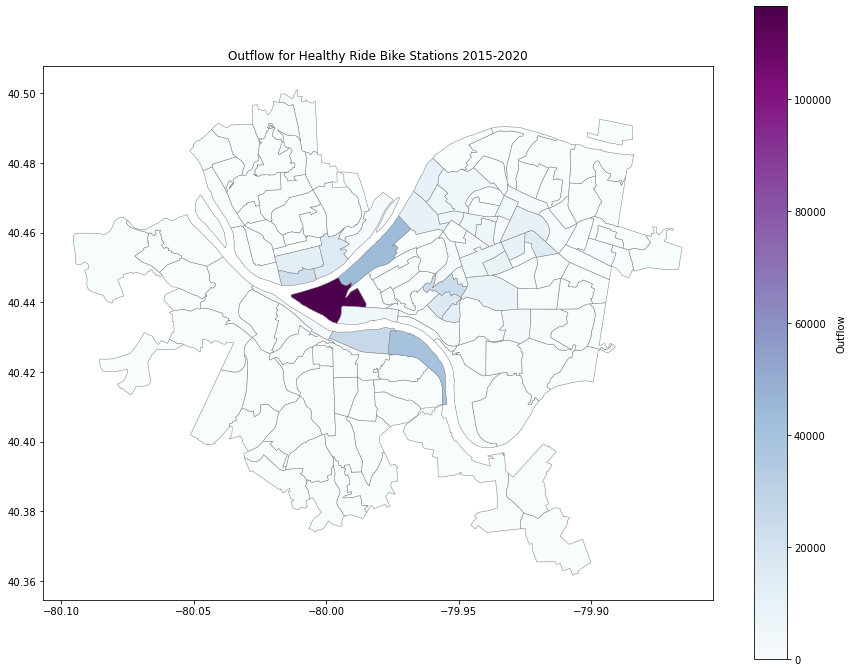

In [142]:
ax = cenTract.plot(column="outflow", cmap='BuPu', figsize = (15, 12), edgecolor = "grey", 
              linewidth = 0.5, legend = True, legend_kwds={'label': "Outflow",'orientation': "vertical"})
plt.title("Outflow for Healthy Ride Bike Stations 2015-2020")

Text(0.5, 1.0, 'Inflow for Healthy Ride Bike Stations 2015-2020')

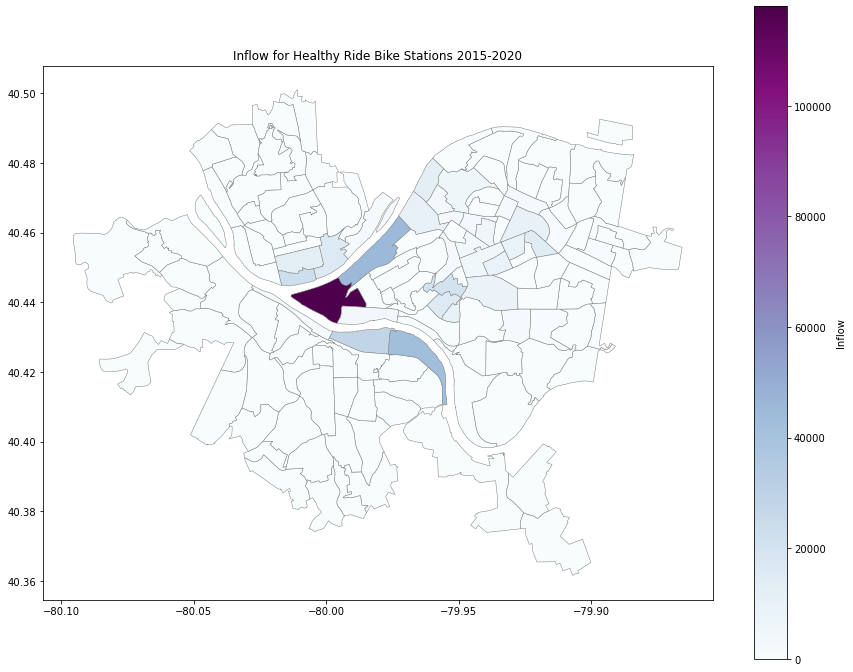

In [143]:
ax = cenTract.plot(column="inflow", cmap='BuPu', figsize = (15, 12), edgecolor = "grey", 
              linewidth = 0.5, legend = True, legend_kwds={'label': "Inflow",'orientation': "vertical"})
plt.title("Inflow for Healthy Ride Bike Stations 2015-2020")

In [183]:
outflow_tract = pd.DataFrame(outflow_dict.values(), index=outflow_dict.keys())

In [189]:
outflow_dict.to_JSON('../Data/PGH/outflow.json')

AttributeError: 'dict' object has no attribute 'to_JSON'

In [184]:
outflow_tract = outflow_tract.reset_index()
outflow_tract = outflow_tract.rename(columns={'index':'tractce10', 0:'outflow'})
outflow_tract

tractce10  outflow
0     020100   116561
1     010300     4858
2     020300    44073
3     981200    21699
4     563200    15607
5     562700    13164
6     981000     4720
7     090100     9840
8     090200     5385
9     090300     5642
10    080900     5756
11    080600     5457
12    111500     9985
13    111400     3731
14    070800    14760
15    070500     9922
16    070300     9207
17    070900     5475
18    982200    24271
19    140100     8411
20    040600    12653
21    040500    16685
22    050100     1160
23    080400     4481
24    160900    39934
25    170200    25736
26    120800      640
27    060300     9643
28    101700      593
29    130300      667
30    140800     1110
31    141300     2838
32    980700     1964
33    040900      982
34    040400     1461
35    562000     2170
36    120700      143
37    111300     2476
38    080700      670
39    240600     2165
40    250300      782

In [185]:
inflow_tract = pd.DataFrame(inflow_dict.values(), index=inflow_dict.keys())
inflow_tract = inflow_tract.reset_index()
inflow_tract = inflow_tract.rename(columns={'index':'tractce10', 0:'inflow'})
inflow_tract

tractce10  inflow
0     020100  117959
1     010300    4235
2     020300   45411
3     981200   23250
4     563200   16419
5     562700   12596
6     981000    5779
7     090100   13184
8     090200    2772
9     090300    3573
10    080900    3679
11    080600    5305
12    111500   10594
13    111400    2006
14    070800   14888
15    070500    9567
16    070300    8832
17    070900    5002
18    982200   21031
19    140100    7973
20    040600   10474
21    040500   15779
22    050100     406
23    080400    3938
24    160900   43185
25    170200   28489
26    120800     615
27    060300   10499
28    101700     335
29    130300     717
30    140800     579
31    141300    1867
32    980700    2070
33    040900    1006
34    040400    1176
35    562000    2037
36    120700     142
37    111300    2511
38    080700     353
39    240600    2194
40    250300     534

In [186]:
flow_df = outflow_tract.merge(inflow_tract, on='tractce10')
flow_df

tractce10  outflow  inflow
0     020100   116561  117959
1     010300     4858    4235
2     020300    44073   45411
3     981200    21699   23250
4     563200    15607   16419
5     562700    13164   12596
6     981000     4720    5779
7     090100     9840   13184
8     090200     5385    2772
9     090300     5642    3573
10    080900     5756    3679
11    080600     5457    5305
12    111500     9985   10594
13    111400     3731    2006
14    070800    14760   14888
15    070500     9922    9567
16    070300     9207    8832
17    070900     5475    5002
18    982200    24271   21031
19    140100     8411    7973
20    040600    12653   10474
21    040500    16685   15779
22    050100     1160     406
23    080400     4481    3938
24    160900    39934   43185
25    170200    25736   28489
26    120800      640     615
27    060300     9643   10499
28    101700      593     335
29    130300      667     717
30    140800     1110     579
31    141300     2838    1867
32    980700     1964    2070
33    040900      982    1006
34    040400     1461    1176
35    562000     2170    2037
36    120700      143     142
37    111300     2476    2511
38    080700      670     353
39    240600     2165    2194
40    250300      782     534

In [187]:
flow_df.to_csv('../Data/PGH/flows.csv')